In [ ]:
!apt-get -qq install fonts-nanum

Selecting previously unselected package fonts-nanum.
(Reading database ... 126101 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.86k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1482 [00:00<?, ?it/s]

Batches:   0%|          | 0/1482 [00:00<?, ?it/s]

Batches:   0%|          | 0/1482 [00:00<?, ?it/s]

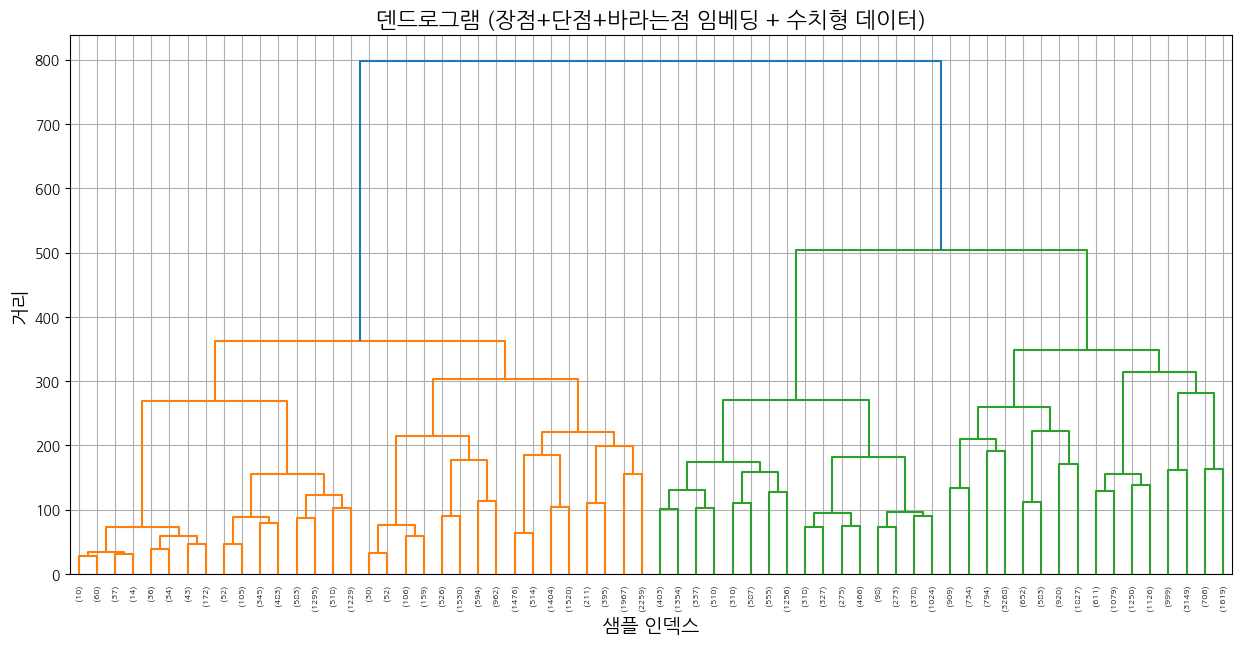

In [ ]:
# 1. ÎùºÏù¥Î∏åÎü¨Î¶¨ Î∂àÎü¨Ïò§Í∏∞
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import TruncatedSVD
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 2. ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï (ÎÇòÎàîÍ≥†Îîï)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
nanum_font = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = nanum_font
plt.rcParams['axes.unicode_minus'] = False

# 3. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df = pd.read_csv('chemistry_all.csv')

# 4. ÏÑúÎπÑÏä§ÏóÖÎßå ÌïÑÌÑ∞ÎßÅ
df_chemistry = df[df['ÏóÖÏ¢Ö'] == 'Ï†úÏ°∞/ÌôîÌïô'].copy()

# Ï¥ùÏ†êÏù¥ 3 Ïù¥ÏÉÅÏù¥Î©¥ Í∏çÏ†ï(1), Í∑∏Î†áÏßÄ ÏïäÏúºÎ©¥ Î∂ÄÏ†ï(0)
df_chemistry['Í∏çÏ†ïÌèâÍ∞Ä'] = (df_chemistry['Ï¥ùÏ†ê'] >= 3).astype(int)

# 5. ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨ (Î∂àÌïÑÏöîÌïú ÎùºÎ≤® Ï†úÍ±∞)
def clean_leading_label(text, label):
    if pd.isnull(text):
        return ''
    return text.replace(label, '').strip()

df_chemistry['Ïû•Ï†ê'] = df_chemistry['Ïû•Ï†ê'].apply(lambda x: clean_leading_label(x, 'Ïû•Ï†ê\n'))
df_chemistry['Îã®Ï†ê'] = df_chemistry['Îã®Ï†ê'].apply(lambda x: clean_leading_label(x, 'Îã®Ï†ê\n'))
df_chemistry['Í≤ΩÏòÅÏßÑÏóê Î∞îÎùºÎäîÏ†ê'] = df_chemistry['Í≤ΩÏòÅÏßÑÏóê Î∞îÎùºÎäîÏ†ê'].apply(lambda x: clean_leading_label(x, 'Í≤ΩÏòÅÏßÑÏóê Î∞îÎùºÎäî Ï†ê\n'))

# 6. BERT ÏûÑÎ≤†Îî© Î™®Îç∏ Î°úÎìú
embedding_model = SentenceTransformer("sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens")

# 7. Ïû•Ï†ê, Îã®Ï†ê, Î∞îÎùºÎäîÏ†ê Í∞ÅÍ∞Å ÏûÑÎ≤†Îî©
embeddings_strengths = embedding_model.encode(df_chemistry['Ïû•Ï†ê'].fillna('').tolist(), show_progress_bar=True)
embeddings_weaknesses = embedding_model.encode(df_chemistry['Îã®Ï†ê'].fillna('').tolist(), show_progress_bar=True)
embeddings_requests = embedding_model.encode(df_chemistry['Í≤ΩÏòÅÏßÑÏóê Î∞îÎùºÎäîÏ†ê'].fillna('').tolist(), show_progress_bar=True)

# 8. ÏàòÏπòÌòï Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú (Ïä§ÏºÄÏùºÎßÅ ÏóÜÏù¥)
numeric_features = ['Ï¥ùÏ†ê', 'ÏäπÏßÑÍ∏∞Ìöå', 'Î≥µÏßÄ/Í∏âÏó¨', 'ÏõåÎùºÎ∞∏', 'ÏÇ¨ÎÇ¥Î¨∏Ìôî', 'Í≤ΩÏòÅÏßÑ', 'Í∏∞ÏóÖÏ∂îÏ≤úÏó¨Î∂Ä']
X_numeric = df_chemistry[numeric_features].fillna(0).values

# 9. ÌÖçÏä§Ìä∏ ÏûÑÎ≤†Îî© + ÏàòÏπòÌòï Í≤∞Ìï©
X_combined = np.hstack([embeddings_strengths, embeddings_weaknesses, embeddings_requests, X_numeric])

# 10. Ï∞®Ïõê Ï∂ïÏÜå (SVD)
#svd = TruncatedSVD(n_components=100, random_state=42)
#X_reduced = svd.fit_transform(X_combined)

# 11. Ward Linkage Íµ∞ÏßëÌôî
Z = linkage(X_combined, method='ward')

# 12. Îç¥ÎìúÎ°úÍ∑∏Îû® ÏãúÍ∞ÅÌôî
plt.figure(figsize=(15, 7))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Îç¥ÎìúÎ°úÍ∑∏Îû® (Ïû•Ï†ê+Îã®Ï†ê+Î∞îÎùºÎäîÏ†ê ÏûÑÎ≤†Îî© + ÏàòÏπòÌòï Îç∞Ïù¥ÌÑ∞)', fontsize=16)
plt.xlabel('ÏÉòÌîå Ïù∏Îç±Ïä§', fontsize=14)
plt.ylabel('Í±∞Î¶¨', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# 16. Íµ∞Ïßë 3Í∞úÎ°ú ÎÇòÎàÑÍ∏∞
df_chemistry['cluster'] = fcluster(Z, t=3, criterion='maxclust')

# 17. Íµ∞ÏßëÎ≥Ñ ÏÉòÌîå Ï∂úÎ†• (3Í∞úÏî©)
cluster_samples = {}
for c in sorted(df_chemistry['cluster'].unique()):
    cluster_samples[c] = df_chemistry[df_chemistry['cluster'] == c][['Ïû•Ï†ê', 'Îã®Ï†ê', 'ÌÜµÌï©ÌèâÍ∞Ä']].head(3).to_dict(orient='records')

# Í≤∞Í≥º ÌôïÏù∏
print(df_chemistry[['cluster', 'Ïû•Ï†ê', 'Îã®Ï†ê', 'ÌÜµÌï©ÌèâÍ∞Ä']].head())
cluster_samples

   cluster                                                 Ïû•Ï†ê  \
0        1                    Í≥ÑÏïΩÏßÅÏù¥ ÏóàÏßÄÎßå ÏùºÌï† Ïàò ÏûàÎäê Ïó¨Îü¨ ÌôòÍ≤Ω ÎßåÏ°±Ïä§Îü¨Ïõ†ÏäµÎãàÎã§   
1        3  ÏùºÎã® ÌöåÏÇ¨Ïùò ÌôòÍ≤Ω ÏûêÏ≤¥Í∞Ä ÍµâÏû•Ìûà Ï¢ãÍ≥†Ïöî, Í∑∏Í≤ÉÍ≥º ÎçîÎ∂àÏñ¥ÏÑú ÌöåÏÇ¨ ÏûêÏ≤¥Ïùò Ïù¥ÎØ∏ÏßÄÍ∞Ä Ï¢ãÏïÑ...   
2        1                   ÏïÑÏπ® Ï†êÏã¨ Ï†ÄÎÖÅ Î¨¥Î£å Ïó¨Î¶ÑÌú¥Í∞Ä 2Ï£º ÏõåÎùºÎ∞∏ Í¥úÏ∞ÆÏùÄ Ìé∏ÏûÖÎãàÎã§   
3        1       ÏïàÏ†ïÏ†ÅÏûÖÎãàÎã§. ÌÅ∞ Î≥ÄÌôîÎäî ÏóÜÏßÄÎßå Í∑∏ÎûòÎèÑ ÏãúÎåÄÏóê Î∞úÎßûÏ∂∞ Î™®ÎëêÍ∞Ä Ïó¥Ïã¨Ìûà ÎÖ∏Î†•Ìï©ÎãàÎã§.   
4        1                     Ï†êÏã¨ÎèÑ Ï£ºÍ≥† ÏπºÌá¥ Í∞ÄÎä•ÌïòÏó¨ ÏõåÎùºÎ∞∏Ïù¥ Î≥¥Ïû•ÎêòÎäî ÌöåÏÇ¨ÏûÖÎãàÎã§   

                                                  Îã®Ï†ê  \
0           Îã®Ï†êÏùÄ ÏïΩÍ∞Ñ ÏúóÎ∂ÑÎì§Ïù¥ Í≥†ÏßÄÏãùÌïú Î∂ÄÎ∂ÑÏù¥ ÏûàÏñ¥ÏÑú ÏãúÌÇ§ÎäîÎåÄÎ°ú Î¨¥Ï°∞Í±¥ Ìï¥ÏïºÌï©ÎãàÎã§   
1            ÏïÑÏâ¨Ïö¥ Ï†êÏù¥ÎùºÎ©¥ Î≥∏Í∞ÄÍ∞Ä ÏàòÎèÑÍ∂åÏù∏ ÏÇ¨ÎûåÏóêÍ≤åÎäî ÎÑàÎ¨¥ Î©ÄÎã§Îäî Í≤ÉÏù¥ Îã®Ï†êÏûÖÎãàÎã§   
2                     Í≥ÑÏïΩ Ïó

{np.int32(1): [{'Ïû•Ï†ê': 'Í≥ÑÏïΩÏßÅÏù¥ ÏóàÏßÄÎßå ÏùºÌï† Ïàò ÏûàÎäê Ïó¨Îü¨ ÌôòÍ≤Ω ÎßåÏ°±Ïä§Îü¨Ïõ†ÏäµÎãàÎã§',
   'Îã®Ï†ê': 'Îã®Ï†êÏùÄ ÏïΩÍ∞Ñ ÏúóÎ∂ÑÎì§Ïù¥ Í≥†ÏßÄÏãùÌïú Î∂ÄÎ∂ÑÏù¥ ÏûàÏñ¥ÏÑú ÏãúÌÇ§ÎäîÎåÄÎ°ú Î¨¥Ï°∞Í±¥ Ìï¥ÏïºÌï©ÎãàÎã§',
   'ÌÜµÌï©ÌèâÍ∞Ä': 'ÏùºÌïòÍ∏∞ Ï¢ãÏùÄ Í∑ºÎ¨¥ÌôòÍ≤ΩÍ≥º Í∏âÏó¨ÎèÑ ÎÇòÏÅòÏßÄ ÏïäÏäµÎãàÎã§'},
  {'Ïû•Ï†ê': 'ÏïÑÏπ® Ï†êÏã¨ Ï†ÄÎÖÅ Î¨¥Î£å Ïó¨Î¶ÑÌú¥Í∞Ä 2Ï£º ÏõåÎùºÎ∞∏ Í¥úÏ∞ÆÏùÄ Ìé∏ÏûÖÎãàÎã§',
   'Îã®Ï†ê': 'Í≥ÑÏïΩ Ïó∞Ïû•Ïù¥ Ïñ¥Î†§ÏõÄ Î∂ÄÏÑúÎ≥ÑÎ°ú Ïó∞Ïû•Í∑ºÎ¨¥ ÌïòÎäî Î∂ÄÏÑúÍ∞Ä ÎßéÏùå',
   'ÌÜµÌï©ÌèâÍ∞Ä': 'Í≥ÑÏïΩÏßÅÏùÄ ÏõåÎùºÎ∞∏ ÏûòÏßÄÏºúÏßÄÍ≥† Ìé∏Ìï©ÎãàÎã§'},
  {'Ïû•Ï†ê': 'ÏïàÏ†ïÏ†ÅÏûÖÎãàÎã§. ÌÅ∞ Î≥ÄÌôîÎäî ÏóÜÏßÄÎßå Í∑∏ÎûòÎèÑ ÏãúÎåÄÏóê Î∞úÎßûÏ∂∞ Î™®ÎëêÍ∞Ä Ïó¥Ïã¨Ìûà ÎÖ∏Î†•Ìï©ÎãàÎã§.',
   'Îã®Ï†ê': 'Í∑ºÎ¨¥Í≥º ÏÑ±Í≥ºÏóê ÎåÄÌï¥ Ï†ÅÏ†àÌïú ÌèâÍ∞ÄÍ∞Ä ÎêòÍ≥† ÏûàÎäîÏßÄ Î™®Î•¥Í≤†ÏäµÎãàÎã§. Ïù¥ Î∂ÄÎ∂ÑÏù¥ Í∞úÏÑ†ÎêòÏñ¥Ïïº Ìï† Í≤É Í∞ôÏäµÎãàÎã§.',
   'ÌÜµÌï©ÌèâÍ∞Ä': 'Î≥ÄÌôîÎ•º Ïó¥Ïã¨Ìûà Ï∂îÍµ¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Í∑ºÎ¨¥ÌôòÍ≤ΩÏùÄ ÏïÑÏ£º Ï¢ãÏßÄ ÏïäÏßÄÎßå ÌöåÏÇ¨ ÏûêÏ≤¥Îäî ÌÉÑÌÉÑÌï©ÎãàÎã§

In [ ]:
# 1. ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨
import numpy as np
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# 2. BERTopic Ï¥àÍ∏∞Ìôî
embedding_model = SentenceTransformer("sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens")
vectorizer_model = CountVectorizer(ngram_range=(1, 1), stop_words=None)

# 3. ÏàòÏπòÌòï Ïª¨Îüº Î¶¨Ïä§Ìä∏
numeric_features = ['Ï¥ùÏ†ê', 'ÏäπÏßÑÍ∏∞Ìöå', 'Î≥µÏßÄ/Í∏âÏó¨', 'ÏõåÎùºÎ∞∏', 'ÏÇ¨ÎÇ¥Î¨∏Ìôî', 'Í≤ΩÏòÅÏßÑ', 'Í∏∞ÏóÖÏ∂îÏ≤úÏó¨Î∂Ä']

# 4. Íµ∞ÏßëÎ≥ÑÎ°ú ÏàòÏπòÌòï Ïä§ÏΩîÏñ¥ + ÌÇ§ÏõåÎìú ÏöîÏïΩ
for c in sorted(df_chemistry['cluster'].unique()):
    print(f"\n\n=========== [Íµ∞Ïßë {c}] ===========\n")

    # (1) Íµ∞ÏßëÎ≥Ñ ÏàòÏπòÌòï Î≥ÄÏàò ÌèâÍ∑†
    temp = df_chemistry[df_chemistry['cluster'] == c]
    numeric_means = temp[numeric_features].mean().round(2)

    print("Íµ∞ÏßëÎ≥Ñ ÌèâÍ∑† Ïä§ÏΩîÏñ¥")
    for col in numeric_features:
        print(f"- {col}: {numeric_means[col]}")

    # (2) Íµ∞ÏßëÎ≥Ñ BERTopic Ï†ÅÏö© Î∞è ÌïµÏã¨ ÌÇ§ÏõåÎìú Ï∂úÎ†•
    print("\n Íµ∞ÏßëÎ≥Ñ ÌïµÏã¨ ÌÇ§ÏõåÎìú (BERTopic Í∏∞Î∞ò)")
    for col in ['Ïû•Ï†ê', 'Îã®Ï†ê', 'Í≤ΩÏòÅÏßÑÏóê Î∞îÎùºÎäîÏ†ê']:
        texts = temp[col].fillna('').tolist()
        if len([t for t in texts if t.strip()]) < 5:
            print(f"  ‚ñ∂ {col} Îç∞Ïù¥ÌÑ∞Í∞Ä Î∂ÄÏ°±ÌïòÏó¨ ÌÇ§ÏõåÎìú Î∂ÑÏÑù ÏÉùÎûµ")
            continue

        topic_model = BERTopic(
            embedding_model=embedding_model,
            vectorizer_model=vectorizer_model,
            top_n_words=7,
            min_topic_size=5,
            verbose=False
        )
        topics, _ = topic_model.fit_transform(texts)
        topic_info = topic_model.get_topic_info()
        top_topic = topic_info.iloc[1]['Topic'] if len(topic_info) > 1 else 0
        keywords = [word for word, _ in topic_model.get_topic(top_topic)]
        print(f"  ‚ñ∂ {col} Top 7 ÌÇ§ÏõåÎìú: {keywords}")



=========== [Íµ∞Ïßë 1] ===========

‚úÖ Íµ∞ÏßëÎ≥Ñ ÌèâÍ∑† Ïä§ÏΩîÏñ¥
- Ï¥ùÏ†ê: 2.92
- ÏäπÏßÑÍ∏∞Ìöå: 2.7
- Î≥µÏßÄ/Í∏âÏó¨: 2.94
- ÏõåÎùºÎ∞∏: 2.83
- ÏÇ¨ÎÇ¥Î¨∏Ìôî: 2.7
- Í≤ΩÏòÅÏßÑ: 2.3
- Í∏∞ÏóÖÏ∂îÏ≤úÏó¨Î∂Ä: 0.4

‚úÖ Íµ∞ÏßëÎ≥Ñ ÌïµÏã¨ ÌÇ§ÏõåÎìú (BERTopic Í∏∞Î∞ò)
  ‚ñ∂ Ïû•Ï†ê Top 7 ÌÇ§ÏõåÎìú: ['Î∞∞Ïö∏', 'Ï†ÑÎ¨∏ÏÑ±ÏùÑ', 'ÏóÖÎ¨¥Î•º', 'Î∞∞Ïö∞Í∏∞', 'Îã§ÏñëÌïú', 'Ï†ÑÎ∞òÏ†ÅÏù∏', 'ÌôïÏã§Ìï¥']
  ‚ñ∂ Îã®Ï†ê Top 7 ÌÇ§ÏõåÎìú: ['ÏÑúÏö∏', 'ÏÇºÏÑ±', 'ÌïúÍµ≠', 'Í±∞Ï†ú', 'ÏÑúÏö∏ÏóêÏÑú', 'ÏÇºÏÑ±Ï†ÑÏûê', 'Íµ∞ÎåÄÎ¨∏Ìôî']
  ‚ñ∂ Í≤ΩÏòÅÏßÑÏóê Î∞îÎùºÎäîÏ†ê Top 7 ÌÇ§ÏõåÎìú: ['Í∑ºÎ¨¥ÌôòÍ≤Ω', 'Í∞úÏÑ†', 'Ï°∞ÏßÅ', 'Î¨∏Ìôî', 'ÏóÖÎ¨¥ÌôòÍ≤Ω', 'Í∑ºÎ¨¥', 'Í∑∏ÎåÄÌôî']


=========== [Íµ∞Ïßë 2] ===========

‚úÖ Íµ∞ÏßëÎ≥Ñ ÌèâÍ∑† Ïä§ÏΩîÏñ¥
- Ï¥ùÏ†ê: 2.77
- ÏäπÏßÑÍ∏∞Ìöå: 2.75
- Î≥µÏßÄ/Í∏âÏó¨: 2.89
- ÏõåÎùºÎ∞∏: 2.73
- ÏÇ¨ÎÇ¥Î¨∏Ìôî: 2.6
- Í≤ΩÏòÅÏßÑ: 2.12
- Í∏∞ÏóÖÏ∂îÏ≤úÏó¨Î∂Ä: 0.34

‚úÖ Íµ∞ÏßëÎ≥Ñ ÌïµÏã¨ ÌÇ§ÏõåÎìú (BERTopic Í∏∞Î∞ò)
  ‚ñ∂ Ïû•Ï†ê Top 7 ÌÇ§ÏõåÎìú: ['ÎÜíÏùÄ', 'Ïó∞Î¥âÏù¥', 'ÏúÑÎ°ú', 'ÏÉÅÏäπÌïòÍ≥†', 'ÏÑ±Ïû•', 'Ïù∏ÏßÄÎèÑÍ∞Ä'

In [ ]:
# ÏàòÏπòÌòï Î≥ÄÏàò Î¶¨Ïä§Ìä∏
numeric_features = ['Ï¥ùÏ†ê', 'ÏäπÏßÑÍ∏∞Ìöå', 'Î≥µÏßÄ/Í∏âÏó¨', 'ÏõåÎùºÎ∞∏', 'ÏÇ¨ÎÇ¥Î¨∏Ìôî', 'Í≤ΩÏòÅÏßÑ', 'Í∏∞ÏóÖÏ∂îÏ≤úÏó¨Î∂Ä']

# Íµ∞ÏßëÎ≥Ñ Í∏∞Ï¥àÌÜµÍ≥ÑÎüâ (describeÎäî count, mean, std, min, 25%, 50%, 75%, max Ìè¨Ìï®)
cluster_stats = df_chemistry.groupby('cluster')[numeric_features].describe()

# Î≥¥Í∏∞ Ï¢ãÍ≤å Ïù∏Îç±Ïä§ Ï†ïÎ¶¨
cluster_stats = cluster_stats.reset_index()

# Í≤∞Í≥º Ï∂úÎ†•
import pandas as pd
pd.set_option('display.max_columns', None)  # Î™®Îì† Ïª¨Îüº Î≥¥Í∏∞
display(cluster_stats)

cluster       Ï¥ùÏ†ê                                                  ÏäπÏßÑÍ∏∞Ìöå  \
             count      mean       std  min  25%  50%  75%  max    count   
0       1  18721.0  2.916564  1.163633  1.0  2.0  3.0  4.0  5.0  18721.0   
1       2   8471.0  2.768740  1.082542  1.0  2.0  3.0  3.0  5.0   8471.0   
2       3  20226.0  3.221695  1.081178  1.0  3.0  3.0  4.0  5.0  20226.0   

                                                  Î≥µÏßÄ/Í∏âÏó¨                      \
       mean       std  min  25%  50%  75%  max    count      mean       std   
0  2.701672  1.105562  1.0  2.0  3.0  3.0  5.0  18721.0  2.941883  1.199777   
1  2.750443  1.018045  1.0  2.0  3.0  3.0  5.0   8471.0  2.888561  1.137262   
2  3.008108  1.040839  1.0  2.0  3.0  4.0  5.0  20226.0  3.241719  1.130961   

                                ÏõåÎùºÎ∞∏                                          \
   min  25%  50%  75%  max    count      mean       std  min  25%  50%  75%   
0  1.0  2.0  3.0  4.0  5.0  18721.0  2.833235  1.279593  1.0  2.0  3.0  4.0   
1  1.0  2.0  3.0  4.0  5.0   8471.0  2.725298  1.263873  1.0  2.0  3.0  4.0   
2  1.0  3.0  3.0  4.0  5.0  20226.0  3.066944  1.247977  1.0  2.0  3.0  4.0   

           ÏÇ¨ÎÇ¥Î¨∏Ìôî                                                   Í≤ΩÏòÅÏßÑ  \
   max    count      mean       std  min  25%  50%  75%  max    count   
0  5.0  18721.0  2.703755  1.221973  1.0  2.0  3.0  4.0  5.0  18721.0   
1  5.0   8471.0  2.599575  1.205838  1.0  2.0  3.0  3.0  5.0   8471.0   
2  5.0  20226.0  3.034559  1.195725  1.0  2.0  3.0  4.0  5.0  20226.0   

                                                 Í∏∞ÏóÖÏ∂îÏ≤úÏó¨Î∂Ä                      \
       mean       std  min  25%  50%  75%  max    count      mean       std   
0  2.295016  1.159171  1.0  1.0  2.0  3.0  5.0  18721.0  0.396881  0.489264   
1  2.118758  1.056521  1.0  1.0  2.0  3.0  5.0   8471.0  0.344942  0.475377   
2  2.578167  1.150373  1.0  2.0  3.0  3.0  5.0  20226.0  0.517601  0.499702   

                            
   min  25%  50%  75%  max  
0  0.0  0.0  0.0  1.0  1.0  
1  0.0  0.0  0.0  1.0  1.0  
2  0.0  0.0  1.0  1.0  1.0

In [ ]:
!pip install bertopic

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 150.6/150.6 kB 14.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13.8/13.8 MB 132.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24.6/24.6 MB 64.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 883.7/883.7 kB 61.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

# Ï†ÑÏ≤¥ Ï†úÏ°∞/ÌôîÌïô Îç∞Ïù¥ÌÑ∞Î°ú ÏòàÏ∏°

In [ ]:
# üîπ ÎùºÏù¥Î∏åÎü¨Î¶¨ Î∂àÎü¨Ïò§Í∏∞
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
X = df_chemistry[['ÏäπÏßÑÍ∏∞Ìöå', 'Î≥µÏßÄ/Í∏âÏó¨', 'ÏõåÎùºÎ∞∏', 'ÏÇ¨ÎÇ¥Î¨∏Ìôî', 'Í≤ΩÏòÅÏßÑ', 'Í∏∞ÏóÖÏ∂îÏ≤úÏó¨Î∂Ä']]
y = df_chemistry['Í∏çÏ†ïÌèâÍ∞Ä']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 2. Ï†ïÍ∑úÌôî
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = []

# 3. Gradient Boosting
gb_params = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01 ,0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4],
    'subsample': [0.8, 1.0]
}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=5, scoring='f1', n_jobs=-1)
gb_grid.fit(X_train, y_train)
gb = gb_grid.best_estimator_
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:, 1]
results.append({
    'Model': 'Gradient Boosting',
    'AUC': roc_auc_score(y_test, y_prob),
    'CA': accuracy_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'Ï†ïÎ∞ÄÎèÑ': precision_score(y_test, y_pred),
    'Ïû¨ÌòÑÏú®': recall_score(y_test, y_pred)
})

# 4. Random Forest
rf_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None,3, 5, 10, 20],
    'max_features': ['sqrt', 'log2', None]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf = rf_grid.best_estimator_
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]
results.append({
    'Model': 'Random Forest',
    'AUC': roc_auc_score(y_test, y_prob),
    'CA': accuracy_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'Ï†ïÎ∞ÄÎèÑ': precision_score(y_test, y_pred),
    'Ïû¨ÌòÑÏú®': recall_score(y_test, y_pred)
})

# 5. Neural Network
nn_params = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'max_iter': [200]
}
nn_grid = GridSearchCV(MLPClassifier(random_state=42), nn_params, cv=5, scoring='f1', n_jobs=-1)
nn_grid.fit(X_train_scaled, y_train)
nn = nn_grid.best_estimator_
y_pred = nn.predict(X_test_scaled)
y_prob = nn.predict_proba(X_test_scaled)[:, 1]
results.append({
    'Model': 'Neural Network',
    'AUC': roc_auc_score(y_test, y_prob),
    'CA': accuracy_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'Ï†ïÎ∞ÄÎèÑ': precision_score(y_test, y_pred),
    'Ïû¨ÌòÑÏú®': recall_score(y_test, y_pred)
})

# 6. AdaBoost
ab_params = {
    'n_estimators': [20, 50, 100],
    'algorithm': ['SAMME']
}
ab_grid = GridSearchCV(AdaBoostClassifier(random_state=42), ab_params, cv=5, scoring='f1', n_jobs=-1)
ab_grid.fit(X_train, y_train)
ab = ab_grid.best_estimator_
y_pred = ab.predict(X_test)
y_prob = ab.predict_proba(X_test)[:, 1]
results.append({
    'Model': 'AdaBoost',
    'AUC': roc_auc_score(y_test, y_prob),
    'CA': accuracy_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'Ï†ïÎ∞ÄÎèÑ': precision_score(y_test, y_pred),
    'Ïû¨ÌòÑÏú®': recall_score(y_test, y_pred)
})

# 7. kNN
knn_params = {
    'n_neighbors': [2, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='f1', n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)
knn = knn_grid.best_estimator_
y_pred = knn.predict(X_test_scaled)
y_prob = knn.predict_proba(X_test_scaled)[:, 1]
results.append({
    'Model': 'kNN',
    'AUC': roc_auc_score(y_test, y_prob),
    'CA': accuracy_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'Ï†ïÎ∞ÄÎèÑ': precision_score(y_test, y_pred),
    'Ïû¨ÌòÑÏú®': recall_score(y_test, y_pred)
})

# ÏµúÏ¢Ö Í≤∞Í≥º Ï∂úÎ†•
df_results = pd.DataFrame(results)
print(df_results.sort_values(by='F1', ascending=False))

               Model       AUC        CA        F1       Ï†ïÎ∞ÄÎèÑ       Ïû¨ÌòÑÏú®
0  Gradient Boosting  0.918007  0.855546  0.899057  0.883307  0.915379
2     Neural Network  0.918119  0.852383  0.897255  0.878178  0.917179
1      Random Forest  0.917537  0.851856  0.896364  0.881602  0.911628
3           AdaBoost  0.916892  0.850274  0.895925  0.875770  0.917029
4                kNN  0.897876  0.849009  0.893942  0.882697  0.905476


In [ ]:
print("Gradient Boosting best params:", gb_grid.best_params_)
print("Random Forest best params:", rf_grid.best_params_)
print("Neural Network best params:", nn_grid.best_params_)
print("AdaBoost best params:", ab_grid.best_params_)
print("kNN best params:", knn_grid.best_params_)

Gradient Boosting best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Random Forest best params: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Neural Network best params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'max_iter': 200, 'solver': 'adam'}
AdaBoost best params: {'algorithm': 'SAMME', 'n_estimators': 100}
kNN best params: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}


In [ ]:
# ÎùºÏù¥Î∏åÎü¨Î¶¨ Î∂àÎü¨Ïò§Í∏∞
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨ Î∞è Ïù∏Îç±Ïä§ Î≥¥Ï°¥
X_all = df_chemistry[['ÏäπÏßÑÍ∏∞Ìöå', 'Î≥µÏßÄ/Í∏âÏó¨', 'ÏõåÎùºÎ∞∏', 'ÏÇ¨ÎÇ¥Î¨∏Ìôî', 'Í≤ΩÏòÅÏßÑ', 'Í∏∞ÏóÖÏ∂îÏ≤úÏó¨Î∂Ä']]
y_all = df_chemistry['Í∏çÏ†ïÌèâÍ∞Ä']
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, stratify=y_all, test_size=0.2, random_state=42
)
train_idx = X_train.index
test_idx = X_test.index

# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôî
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)
df_chemistry_scaled = pd.DataFrame(X_scaled, index=df_chemistry.index, columns=X_all.columns)

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Í≤∞Í≥º Ï†ÄÏû•Ïö©
cluster_id_map = {original: f"Íµ∞Ïßë{idx+1}" for idx, original in enumerate(sorted(df_chemistry['cluster'].dropna().unique()))}
results_cluster = []

# Íµ∞ÏßëÎ≥Ñ Î™®Îç∏ Ï†ÅÏö©
for c in sorted(df_chemistry['cluster'].dropna().unique()):
    cluster_df = df_chemistry[df_chemistry['cluster'] == c]
    cname = cluster_id_map[c]

    X_c = df_chemistry_scaled.loc[cluster_df.index]
    y_c = cluster_df['Í∏çÏ†ïÌèâÍ∞Ä']

    # Ïù∏Îç±Ïä§ Í∏∞Î∞òÏúºÎ°ú train/test split Ïú†ÏßÄ
    train_ids = train_idx.intersection(cluster_df.index)
    test_ids = test_idx.intersection(cluster_df.index)

    if y_c.loc[train_ids].nunique() < 2 or y_c.loc[test_ids].nunique() < 2:
        continue

    # Gradient Boosting
    gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8, random_state=42)
    gb.fit(X_c.loc[train_ids], y_c.loc[train_ids])
    y_pred = gb.predict(X_c.loc[test_ids])
    y_prob = gb.predict_proba(X_c.loc[test_ids])[:, 1]

    results_cluster.append({
        'Model': 'Gradient Boosting',
        'Cluster': cname,
        'AUC': roc_auc_score(y_c.loc[test_ids], y_prob),
        'CA': accuracy_score(y_c.loc[test_ids], y_pred),
        'F1': f1_score(y_c.loc[test_ids], y_pred),
        'Ï†ïÎ∞ÄÎèÑ': precision_score(y_c.loc[test_ids], y_pred),
        'Ïû¨ÌòÑÏú®': recall_score(y_c.loc[test_ids], y_pred)
    })

    # Neural Network
    nn = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                       alpha=0.0001, max_iter=200, random_state=42)
    nn.fit(X_c.loc[train_ids], y_c.loc[train_ids])
    y_pred = nn.predict(X_c.loc[test_ids])
    y_prob = nn.predict_proba(X_c.loc[test_ids])[:, 1]

    results_cluster.append({
        'Model': 'Neural Network',
        'Cluster': cname,
        'AUC': roc_auc_score(y_c.loc[test_ids], y_prob),
        'CA': accuracy_score(y_c.loc[test_ids], y_pred),
        'F1': f1_score(y_c.loc[test_ids], y_pred),
        'Ï†ïÎ∞ÄÎèÑ': precision_score(y_c.loc[test_ids], y_pred),
        'Ïû¨ÌòÑÏú®': recall_score(y_c.loc[test_ids], y_pred)
    })

# Í≤∞Í≥º Ï∂úÎ†•
df_cluster_result = pd.DataFrame(results_cluster)
display(df_cluster_result.sort_values(by=['Cluster', 'Model']))

Model Cluster       AUC        CA        F1       Ï†ïÎ∞ÄÎèÑ       Ïû¨ÌòÑÏú®
0  Gradient Boosting     Íµ∞Ïßë1  0.921791  0.852965  0.890069  0.882496  0.897774
1     Neural Network     Íµ∞Ïßë1  0.921039  0.851052  0.889025  0.878471  0.899835
2  Gradient Boosting     Íµ∞Ïßë2  0.908231  0.828839  0.864438  0.856486  0.872540
3     Neural Network     Íµ∞Ïßë2  0.911043  0.832943  0.865248  0.873092  0.857545
4  Gradient Boosting     Íµ∞Ïßë3  0.913636  0.863074  0.912963  0.894196  0.932535
5     Neural Network     Íµ∞Ïßë3  0.913842  0.865259  0.914100  0.897841  0.930958

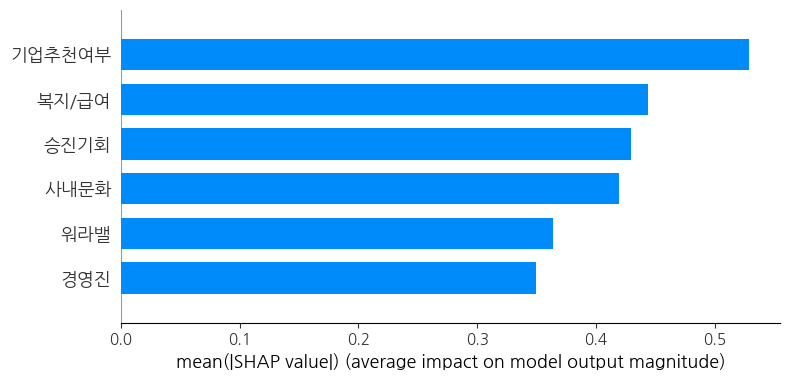

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. Íµ∞Ïßë 3 Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú Î∞è Ï†ïÍ∑úÌôîÎêú Í∞í ÏÇ¨Ïö©
cluster_3_idx = df_chemistry[df_chemistry['cluster'] == 3].index
X_cluster_3 = df_chemistry_scaled.loc[cluster_3_idx]
y_cluster_3 = df_chemistry.loc[cluster_3_idx, 'Í∏çÏ†ïÌèâÍ∞Ä']

# 2. ÌïôÏäµ/ÌÖåÏä§Ìä∏ Ïù∏Îç±Ïä§ Ïú†ÏßÄ
train_ids = train_idx.intersection(cluster_3_idx)
test_ids = test_idx.intersection(cluster_3_idx)

# 3. Gradient Boosting Î™®Îç∏ Ï†ïÏùò Î∞è ÌïôÏäµ
gb_model = GradientBoostingClassifier(
    learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8, random_state=42
)
gb_model.fit(X_cluster_3.loc[train_ids], y_cluster_3.loc[train_ids])

# 4. SHAP Í∞í Í≥ÑÏÇ∞ (TreeExplainer ÏÇ¨Ïö©)
explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(X_cluster_3.loc[test_ids])

# 5. ÏãúÍ∞ÅÌôî (summary_plot)
shap.summary_plot(
    shap_values,
    X_cluster_3.loc[test_ids],
    feature_names=X_cluster_3.columns,
    plot_type="bar"  # ÎòêÎäî "dot"
)

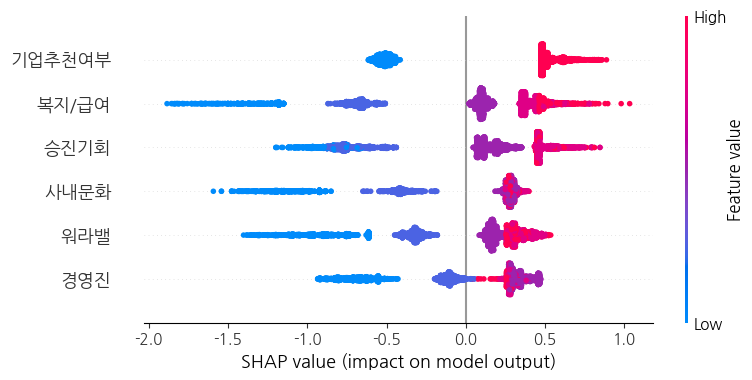

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. SHAP explainer (Tree Î™®Îç∏Ïù¥ÎØÄÎ°ú TreeExplainer)
explainer = shap.TreeExplainer(gb_model)

# 2. SHAP Í∞í Í≥ÑÏÇ∞
shap_values = explainer.shap_values(X_cluster_3.loc[test_ids])

# 3. SHAP summary Î∂ÑÏÇ∞ plot (dot plot) ÏãúÍ∞ÅÌôî
shap.summary_plot(
    shap_values,
    X_cluster_3.loc[test_ids],
    feature_names=X_cluster_3.columns,
    plot_type="dot",       # default; ÎèôÏùºÌïú Ïä§ÌÉÄÏùº
    show=True
)